In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import csv
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


In [106]:
df_hospital=pd.read_csv("processed_data/dublinbikes_james_hospital.csv")
df_portobello=pd.read_csv("processed_data/dublinbikes_portobello.csv")

Thin out the data

In [108]:
df_hospital=df_hospital.iloc[::2, :]
df_portobello=df_portobello.iloc[::2, :]


,TIME,BIKE STANDS,AVAILABLE BIKES
0,2020-01-28 00:00:02,40,20
2,2020-01-28 00:10:02,40,20
4,2020-01-28 00:20:02,40,20
6,2020-01-28 00:30:02,40,20
8,2020-01-28 00:40:02,40,20
...,...,...,...
12950,2020-03-12 23:10:02,40,23
12952,2020-03-12 23:20:02,40,22
12954,2020-03-12 23:30:02,40,22
12956,2020-03-12 23:40:02,40,22


Lets get some basic features like day of week, weekend, time

In [109]:
def get_basic_features(df:pd.DataFrame):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["DAY OF WEEK"]=df["TIME"].dt.dayofweek-1
    df["HOUR"]=df["TIME"].dt.strftime("%H").astype(int)
    df["MINUTE"]=df["TIME"].dt.strftime("%M").astype(int)

    return df

In [110]:
df_hospital_map={}
df_portobello_map={}

Lets add some more complex features using weekly, daily and short-term seasonality trends in the data

For short term trends lets use intervals of 15 min, and get the last three intervals

In [111]:
def get_trend_features(df:pd.DataFrame):
    df["CURRENT AVAILABILITY"] = df["AVAILABLE BIKES"]
    df["10MIN AGO"] = df["AVAILABLE BIKES"].shift(2)
    df["20MIN AGO"] = df["AVAILABLE BIKES"].shift(4)
    df["30MIN AGO"] = df["AVAILABLE BIKES"].shift(6)
    df["60MIN AGO"] = df["AVAILABLE BIKES"].shift(12)

    
    df.dropna(inplace=True)
    return df

In [112]:
def shift_target_variable(df:pd.DataFrame, prediction_time : int):
    df=df.copy(deep=True)
    prediction_int = np.trunc(prediction_time/5) 
    prediction_int=prediction_int.astype(int)
    df["CURRENT AVAILABILITY"]=df["CURRENT AVAILABILITY"].shift(prediction_int)
    df["10MIN AGO"]=df["10MIN AGO"].shift(prediction_int)
    df["20MIN AGO"]=df["20MIN AGO"].shift(prediction_int)
    df["30MIN AGO"] = df["30MIN AGO"].shift(prediction_int)
    df["60MIN AGO"]= df["60MIN AGO"].shift(prediction_int)
    df.dropna(inplace=True)
    df.drop("WEEKEND",inplace=True,axis=1)
    return df

In [113]:
def get_seasonal_features(df:pd.DataFrame):

    df["ONE WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKDAY AGO"].fillna(0,inplace=True)
    df["ONE WEEKENDDAY AGO"] = df.loc[df["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKENDDAY AGO"].fillna(0, inplace=True)
    df["1 DAY AGO"] = df["ONE WEEKDAY AGO"] + df["ONE WEEKENDDAY AGO"]

    df["2 WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKDAY AGO"].fillna(0,inplace=True)
    df["2 WEEKENDDAY AGO"] = df.loc[df["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKENDDAY AGO"].fillna(0, inplace=True)
    
    df["2 DAYS AGO"] = df["2 WEEKDAY AGO"] + df["2 WEEKENDDAY AGO"]

    df.drop(["2 WEEKENDDAY AGO","2 WEEKDAY AGO","ONE WEEKDAY AGO","ONE WEEKENDDAY AGO"],inplace=True,axis=1)

    df["1 WEEK AGO"] = df["AVAILABLE BIKES"].shift(12*24*7)

    df.dropna(inplace=True)
    return df

In [114]:
def normalize_features(df:pd.DataFrame):
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"]/df["BIKE STANDS"]
    """df["DAY OF WEEK"] = df["DAY OF WEEK"] / 6
    df["HOUR"] = df["HOUR"] / max(df["HOUR"])
    df["MINUTE"] = df["MINUTE"] / max(df["MINUTE"])"""
    return df

In [115]:
def calc_weekend_column(df):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["WEEKEND"] = df["TIME"].dt.dayofweek >=5
    return df


In [116]:

calc_weekend_column(df_hospital)
calc_weekend_column(df_portobello)

df_hospital.set_index("TIME",inplace=True,drop=True)
df_portobello.set_index("TIME",inplace=True,drop=True)


df_hospital=normalize_features(df_hospital)
df_portobello=normalize_features(df_portobello)


df_hospital=get_trend_features(df_hospital)
df_portobello=get_trend_features(df_portobello)


keys = ["10MIN","30MIN","60MIN"]
for key in keys:
    df_hospital_map[key] = get_seasonal_features(df_hospital)
    df_portobello_map[key] = get_seasonal_features(df_portobello)



df_hospital_map["10MIN"]=shift_target_variable(df_hospital_map["10MIN"], prediction_time = 10)
df_portobello_map["10MIN"]=shift_target_variable(df_portobello_map["10MIN"], prediction_time = 10)

df_hospital_map["30MIN"]=shift_target_variable(df_hospital_map["30MIN"], prediction_time = 30)
df_portobello_map["30MIN"]=shift_target_variable(df_portobello_map["30MIN"], prediction_time = 30)

df_hospital_map["60MIN"]=shift_target_variable(df_hospital_map["60MIN"], prediction_time = 60)
df_portobello_map["60MIN"]=shift_target_variable(df_portobello_map["60MIN"], prediction_time =  60)


"""df_hospital_map["30MIN"] = df_hospital_map["30MIN"].iloc[:-4]
df_portobello_map["30MIN"]= df_portobello_map["30MIN"].iloc[:-4]
df_hospital_map["10MIN"] = df_hospital_map["10MIN"].iloc[:-8]
df_portobello_map["10MIN"]= df_portobello_map["10MIN"].iloc[:-8]"""



'df_hospital_map["30MIN"] = df_hospital_map["30MIN"].iloc[:-4]\ndf_portobello_map["30MIN"]= df_portobello_map["30MIN"].iloc[:-4]\ndf_hospital_map["10MIN"] = df_hospital_map["10MIN"].iloc[:-8]\ndf_portobello_map["10MIN"]= df_portobello_map["10MIN"].iloc[:-8]'

In [117]:
def get_X_and_y(df:map):
    X={}
    y={}
    y["10MIN"]=df["10MIN"]["AVAILABLE BIKES"]
    X["10MIN"] = df["10MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["30MIN"]=df["30MIN"]["AVAILABLE BIKES"]
    X["30MIN"] = df["30MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["60MIN"]=df["60MIN"]["AVAILABLE BIKES"]
    X["60MIN"] = df["60MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    return X,y

In [118]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)


In [119]:
ridge_model_portobello = {}
ridge_model_hospital = {}

for key in X_portobello.keys():
    ridge_model_portobello[key]=Ridge().fit(X_portobello[key],y_portobello[key])
    ridge_model_hospital[key]=Ridge().fit(X_hospital[key],y_hospital[key])



In [120]:
ridge_model_hospital["60MIN"].coef_

array([ 0.92485949, -0.09019769, -0.0509534 , -0.05025273,  0.07607831,
        0.11708377,  0.02135197,  0.03930217])

In [121]:


hospital_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_hospital["10MIN"].coef_,
"30 Min Prediciton":ridge_model_hospital["30MIN"].coef_,
"60 Min Prediciton":ridge_model_hospital["60MIN"].coef_
})

portobello_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_portobello["10MIN"].coef_,
"30 Min Prediciton":ridge_model_portobello["30MIN"].coef_,
"60 Min Prediciton":ridge_model_portobello["60MIN"].coef_
})

hospital_features_df.set_index("Feature Name",inplace=True)
portobello_features_df.set_index("Feature Name",inplace=True)


hospital_features_df

,10 Min Prediciton,30 Min Prediciton,60 Min Prediciton
Feature Name,,,
CURRENT AVAILABILITY,1.056191,1.009736,0.924859
10MIN AGO,-0.064506,-0.078417,-0.090198
20MIN AGO,-0.023510,-0.007830,-0.050953
30MIN AGO,0.008986,-0.031105,-0.050253
60MIN AGO,-0.008401,0.008124,0.076078
1 DAY AGO,0.016647,0.057886,0.117084
2 DAYS AGO,-0.000225,0.006152,0.021352
1 WEEK AGO,0.003216,0.016920,0.039302


Text(0.5, 1.0, 'St James Hospital Bike Station')

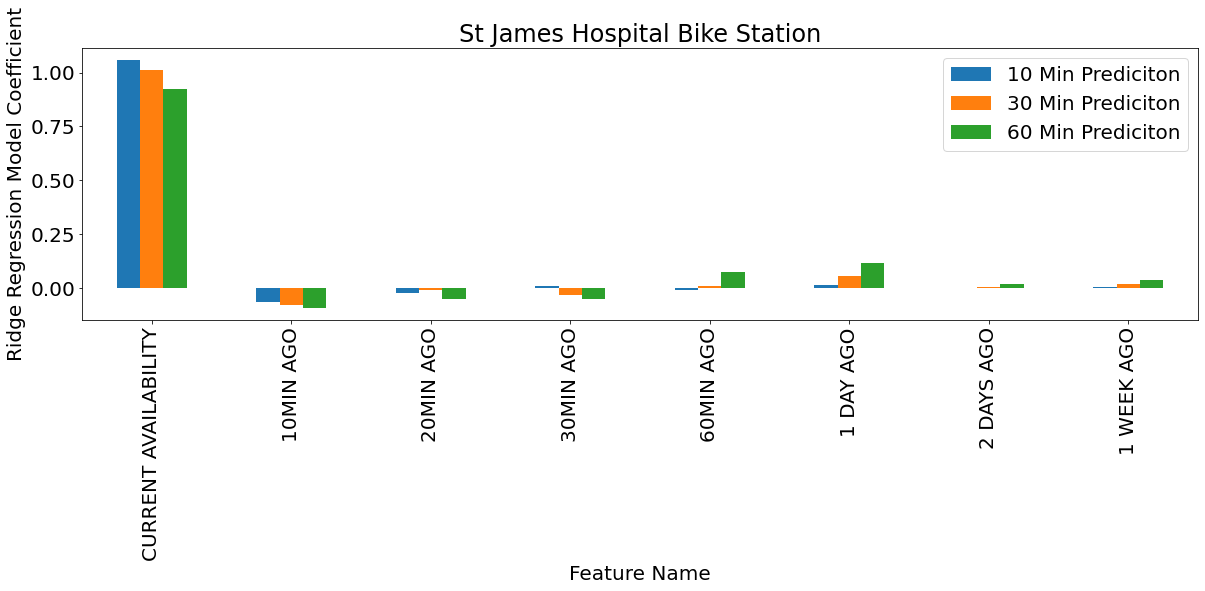

In [122]:
plt.rc('font',size=20)
hospital_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("St James Hospital Bike Station")

Text(0.5, 1.0, 'Portobello Bike Station')

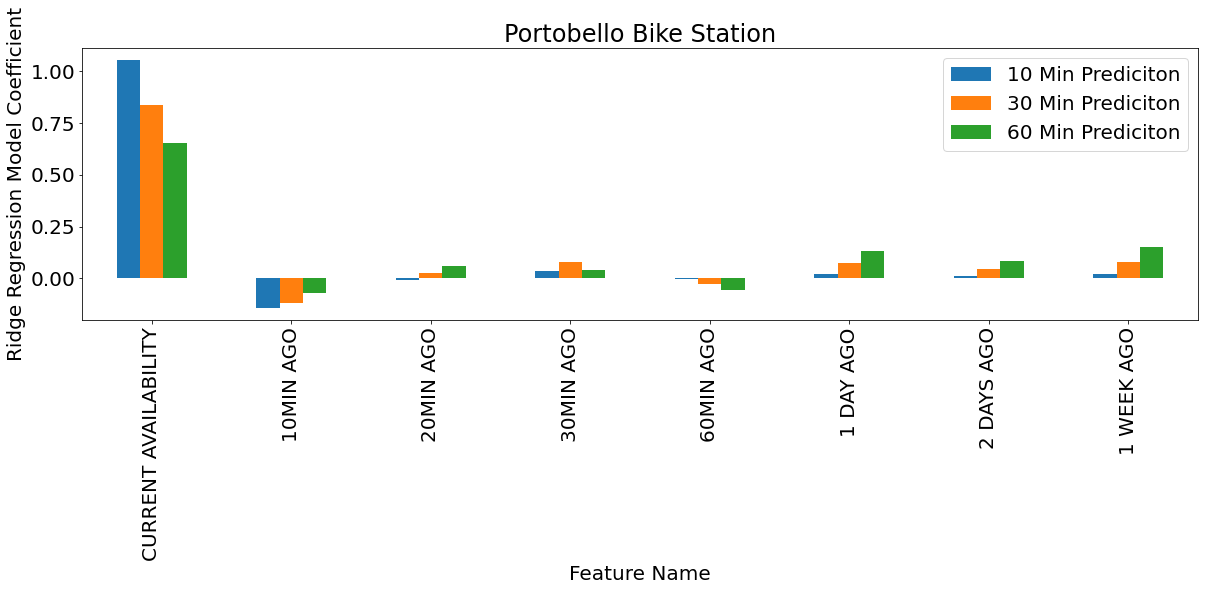

In [123]:
plt.rc('font',size=20)
portobello_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("Portobello Bike Station")

Lets drop the irrelevant fields based on our bar charts

In [124]:
df_portobello_map["10MIN"]

,BIKE STANDS,AVAILABLE BIKES,CURRENT AVAILABILITY,10MIN AGO,20MIN AGO,30MIN AGO,60MIN AGO,1 DAY AGO,2 DAYS AGO,1 WEEK AGO
TIME,,,,,,,,,,
2020-02-18 01:10:02,30,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.733333,0.833333,0.566667
2020-02-18 01:15:02,30,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.733333,0.833333,0.566667
2020-02-18 01:20:02,30,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.733333,0.833333,0.566667
2020-02-18 01:25:02,30,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.733333,0.833333,0.566667
2020-02-18 01:30:02,30,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.733333,0.833333,0.566667
...,...,...,...,...,...,...,...,...,...,...
2020-03-12 23:35:02,30,0.800000,0.800000,0.8,0.733333,0.733333,0.733333,0.933333,0.966667,1.000000
2020-03-12 23:40:02,30,0.833333,0.800000,0.8,0.766667,0.733333,0.733333,0.966667,0.933333,1.000000
2020-03-12 23:45:02,30,0.866667,0.800000,0.8,0.800000,0.733333,0.733333,1.000000,0.933333,1.000000


In [125]:
df_hospital_map["10MIN"].drop(["30MIN AGO", "60MIN AGO", "1 DAY AGO", "2 DAYS AGO", "1 WEEK AGO"], axis=1,inplace=True)
df_hospital_map["30MIN"].drop(["20MIN AGO", "60MIN AGO", "2 DAYS AGO", "1 WEEK AGO"], axis=1,inplace=True)
df_hospital_map["60MIN"].drop(["2 DAYS AGO", "1 WEEK AGO"], axis=1,inplace=True)


In [126]:
df_portobello_map["10MIN"].drop(["20MIN AGO", "60MIN AGO", "1 DAY AGO", "2 DAYS AGO", "1 WEEK AGO"], axis=1,inplace=True)
df_portobello_map["30MIN"].drop(["20MIN AGO", "60MIN AGO","30MIN AGO"], axis=1,inplace=True)
df_portobello_map["60MIN"].drop(["20MIN AGO","30MIN AGO","60MIN AGO"], axis=1,inplace=True)


In [127]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)